# Simple ring parameter constraints

This notebook provides test cases for the precision of a simple lens model (with simplified assumptions). This is for show-casing and to assess the uncertainty limit in how well the parameters of this model can be constrained.


In [1]:
# import of standard python libraries
import copy
import numpy as np
import matplotlib.pyplot as plt

# import main simulation class of lenstronomy
from lenstronomy.Util import util, image_util
from lenstronomy.Data.psf import PSF
from lenstronomy.Workflow.fitting_sequence import FittingSequence as FittingSequence_ref

from jaxtronomy.Workflow.fitting_sequence import FittingSequence
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.Data.imaging_data import ImageData
from jaxtronomy.ImSim.image_model import ImageModel

# Currently, jaxtronomy supports the following deflector and source profiles:
from jaxtronomy.LensModel.profile_list_base import _JAXXED_MODELS as _JAXXED_DEFLECTOR_MODELS
from jaxtronomy.LightModel.light_model_base import _JAXXED_MODELS as _JAXXED_LIGHT_MODELS
print("Deflector models:", _JAXXED_DEFLECTOR_MODELS)
print("Light models:", _JAXXED_LIGHT_MODELS)

Deflector models: ['CONVERGENCE', 'CSE', 'EPL', 'EPL_Q_PHI', 'GAUSSIAN', 'GAUSSIAN_POTENTIAL', 'HERNQUIST', 'HERNQUIST_ELLIPSE_CSE', 'LOS', 'LOS_MINIMAL', 'NFW', 'NFW_ELLIPSE_CSE', 'NIE', 'PJAFFE', 'PJAFFE_ELLIPSE_POTENTIAL', 'SHEAR', 'SIE', 'SIS', 'SPP']
Light models: ['GAUSSIAN', 'GAUSSIAN_ELLIPSE', 'MULTI_GAUSSIAN', 'MULTI_GAUSSIAN_ELLIPSE', 'SERSIC', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE_Q_PHI', 'CORE_SERSIC']


## simulation choices

In [2]:
# data specifics
background_rms = .005  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size per axis
pixel_scale = 0.11  #  pixel size in arcsec (area per pixel = pixel_scale**2)
fwhm = 0.05  # full width at half maximum of PSF

# lensing quantities
lens_model_list = ['EPL', 'SHEAR']
kwargs_epl = {'theta_E': 1.66, 'gamma': 1.7, 'e1': .07, 'e2': -0.03, 'center_x': 0.01, 'center_y': -0.01}
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}

if lens_model_list[0] == "SIE":
    kwargs_epl.pop('gamma')

kwargs_lens = [kwargs_epl, kwargs_shear]
lens_model_class = LensModel(lens_model_list)


# Sersic parameters in the initial simulation for the source
kwargs_sersic = {'amp': 26., 'R_sersic': 0.1, 'n_sersic': 1., 'e1': -0.1, 'e2': 0.1, 'center_x': 0.01, 'center_y': -0.01}
source_model_list = ['SERSIC_ELLIPSE']

kwargs_source = [kwargs_sersic]
source_model_class = LightModel(source_model_list)


kwargs_sersic_lens = {'amp': 16., 'R_sersic': 0.6, 'n_sersic': 2., 'e1': -0.1, 'e2': 0.1, 'center_x': 0.01, 'center_y': -0.01}

lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]

kwargs_truth = {'kwargs_lens': kwargs_lens,
                'kwargs_source': kwargs_source,
                'kwargs_lens_light': kwargs_lens_light}

        
lens_light_model_class = LightModel(lens_light_model_list)


## Simulating a mock lens
In the blocks below we simulate a mock lens to generate an image. We only require the kwargs_data and kwargs_psf arguments to perform the modeling. If you have real data, you can leave out the image simulation and directly read in the data, PSF and noise properties into the keyword argument list. Make sure the units are correct. Further information on the settings are available in the ImageData() and PSF() classes in the lenstronomy.Data module.

In [3]:
# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=pixel_scale, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }
data_class = ImageData(**kwargs_data)


# generate the psf variables
kwargs_psf_gaussian = {'psf_type': 'GAUSSIAN', 'pixel_size': pixel_scale, 'fwhm': 0.5}
psf_class = PSF(**kwargs_psf_gaussian)


kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False, 'convolution_type': 'fft_static'}


# create ImageModel class and generate image
imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None, point_source_add=False)

# Can add noise if desired
poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_model += poisson + bkg

kwargs_data['image_data'] = image_model

data_class.update_data(image_model)


## Defining a Prior Distribution
Now that we have our data image, our goal is to sample through the parameter space to recover the true parameters of the lens that generated this image. First, we define a prior distribution to pass into our samplers.

In [4]:
# deflector priors
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# Since our deflector model consists of ["EPL", "SHEAR"], we first define priors for the EPL
fixed_lens.append({})
kwargs_lens_init.append({'theta_E': 2., 'gamma': 2.1, 'e1': 0.13, 'e2': -0.06, 'center_x': 0.1, 'center_y': 0.2})
kwargs_lens_sigma.append({'theta_E': 0.1, 'gamma': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 1.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10., 'center_y': -10.})
kwargs_upper_lens.append({'theta_E': 10., 'gamma': 2.5, 'e1': 0.5, 'e2': 0.5, 'center_x': 10., 'center_y': 10.})

if lens_model_list[0] == "SIE":
    kwargs_lens_init[0].pop('gamma')
    kwargs_lens_sigma[0].pop('gamma')
    kwargs_lower_lens[0].pop('gamma')
    kwargs_upper_lens[0].pop('gamma')

# Now we define priors for the SHEAR
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0.1, 'gamma2': 0.04})
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


# source priors
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'amp': 36, 'e1': 0.1, 'e2': 0.1, 'R_sersic': 0.2, 'n_sersic': 2.5, 'center_x': 0.3, 'center_y': 0.})
kwargs_source_sigma.append({'amp': 1, 'e1': 0.05, 'e2': 0.05, 'R_sersic': 0.01, 'n_sersic': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'amp': 0, 'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10., 'center_y': -10.})
kwargs_upper_source.append({'amp': 100, 'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


# Lens light priors
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'amp': 7, 'e1': 0.1, 'e2': 0.3, 'R_sersic': 0.5, 'n_sersic': 2., 'center_x': 0.1, 'center_y': 0.})
kwargs_lens_light_sigma.append({'amp': 1, 'e1': 0.05, 'e2': 0.05, 'R_sersic': 0.03, 'n_sersic': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'amp': 0, 'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10., 'center_y': -10})
kwargs_upper_lens_light.append({'amp': 100, 'e1': 0.5, 'e2': 0.5, 'R_sersic': 10., 'n_sersic': 5., 'center_x': 10., 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


## FittingSequence
This class holds all of the image generation choices, the data image, the likelihood calculation choices, the choices for which methods are used to sample through the parameter space, and the current distribution/best fit parameters (updated after each sampler finishes running), which are currently set to the prior distributions defined above.

We compare the performances of the jaxtronomy modeling pipeline to that of lenstronomy.

In [5]:
# Only image likelihood is currently supported in jaxtronomy
kwargs_likelihood = {
        'check_bounds': True, # Checks if sampler goes out of bounds during sampling
        'image_likelihood': True,
        'time_delay_likelihood': False,
        'tracer_likelihood': False,
        'image_position_likelihood': False,
        'source_position_likelihood': False,
        'flux_ratio_likelihood': False,
        'kinematic_2d_likelihood': False,
        'astrometric_likelihood': False,
}
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list}

# Currently only single-band is supported in jaxtronomy
multi_band_list = [[kwargs_data, kwargs_psf_gaussian, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'
                    }
kwargs_constraints = {'linear_solver': False} # Linear solver is not supported in jaxtronomy

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_seq_ref = FittingSequence_ref(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

#
fitting_kwargs_list_mcmc = [['PSO', {'sigma_scale': 1., 'n_particles': 50, 'n_iterations': 250}],
                       ['MCMC', {'n_burn': 50, 'n_run': 200, 'n_walkers': 50, 'sigma_scale': 1.}],
        ]

In [6]:
# Run the lenstronomy fitting sequence for PSO + MCMC
chain_list = fitting_seq_ref.fit_sequence(fitting_kwargs_list_mcmc)

print(fitting_seq_ref.best_fit())
print("kwargs_truths:", kwargs_truth)

Computing the PSO ...


100%|██████████| 250/250 [00:49<00:00,  5.10it/s]


Max iteration reached! Stopping.
-1.0774922587312685 reduced X^2 of best position
-1927.6336508702393 log likelihood
3578 effective number of data points
[{'theta_E': 1.6838905361704697, 'gamma': 1.743974971718976, 'e1': 0.17156699864696187, 'e2': 0.051614377147312505, 'center_x': 0.0035582302102905045, 'center_y': -0.0045476755554456514}, {'gamma1': 0.044977015552026295, 'gamma2': -0.004680647489287386, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 29.30016514476354, 'R_sersic': 0.13137807331546716, 'n_sersic': 0.5036832607845895, 'e1': -0.11539772773126061, 'e2': 0.02665098202753608, 'center_x': 0.005408471978653983, 'center_y': -0.0038748737870657264}] source result
[{'amp': 15.724255658895796, 'R_sersic': 0.6094511505170007, 'n_sersic': 1.9798214271145071, 'e1': -0.1019393162787736, 'e2': 0.10537276066653371, 'center_x': 0.01095678670295559, 'center_y': -0.0061586435351085106}] lens light result
[] point source result
[] tracer source result
{} special param result
49.06589865684509

100%|██████████| 250/250 [00:42<00:00,  5.90it/s]

Computing the MCMC...
Number of walkers =  50
Burn-in iterations:  50
Sampling iterations (in current run): 250
42.512521266937256 time taken for MCMC sampling
{'kwargs_lens': [{'theta_E': 1.6823386405516196, 'gamma': 1.7349247085110349, 'e1': 0.1636555546858134, 'e2': 0.04358626670916634, 'center_x': 0.010303637754507666, 'center_y': -0.009228110757253452}, {'gamma1': 0.04422329768511768, 'gamma2': -0.007586459363690366, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 28.89653504222751, 'R_sersic': 0.12597716131928824, 'n_sersic': 0.5905496220676287, 'e1': -0.12871114475050544, 'e2': 0.028337333654590006, 'center_x': 0.010420718850283194, 'center_y': -0.009584464755652704}], 'kwargs_lens_light': [{'amp': 15.828452553966214, 'R_sersic': 0.6028594702433147, 'n_sersic': 1.9765555969840074, 'e1': -0.10519139828011734, 'e2': 0.11426216685373888, 'center_x': 0.010647324982498605, 'center_y': 0.004369463926142982}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_t

In [7]:
# Run the jaxtronomy fitting sequence for PSO + MCMC
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)

print(fitting_seq_ref.best_fit())
print("kwargs_truths:", kwargs_truth)

Computing the PSO ...


100%|██████████| 250/250 [00:19<00:00, 12.94it/s]


Max iteration reached! Stopping.
-0.9898055989575932 reduced X^2 of best position
-1770.7622165351343 log likelihood
3578 effective number of data points
[{'theta_E': 1.643261269252508, 'gamma': 2.4972841335430878, 'e1': 0.07954716418364612, 'e2': -0.10764350778702679, 'center_x': 0.009358138454851164, 'center_y': -0.013631134507492008}, {'gamma1': -0.06517658204384136, 'gamma2': -0.08880230112820799, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 23.49533100083229, 'R_sersic': 0.1994176617917116, 'n_sersic': 1.2785362065706294, 'e1': -0.04430575642630369, 'e2': 0.13623150156699726, 'center_x': 0.008986621621141236, 'center_y': -0.013344664844121593}] source result
[{'amp': 14.418275184086939, 'R_sersic': 0.6454094187947209, 'n_sersic': 2.0087540487740783, 'e1': -0.08871399876216152, 'e2': 0.09218795867138103, 'center_x': 0.015374811824572437, 'center_y': 0.010953105115918309}] lens light result
[] point source result
[] tracer source result
{} special param result
19.362061977386475 tim

100%|██████████| 250/250 [00:20<00:00, 12.30it/s]

Computing the MCMC...
Number of walkers =  50
Burn-in iterations:  50
Sampling iterations (in current run): 250
20.85234260559082 time taken for MCMC sampling
{'kwargs_lens': [{'theta_E': 1.6823386405516196, 'gamma': 1.7349247085110349, 'e1': 0.1636555546858134, 'e2': 0.04358626670916634, 'center_x': 0.010303637754507666, 'center_y': -0.009228110757253452}, {'gamma1': 0.04422329768511768, 'gamma2': -0.007586459363690366, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 28.89653504222751, 'R_sersic': 0.12597716131928824, 'n_sersic': 0.5905496220676287, 'e1': -0.12871114475050544, 'e2': 0.028337333654590006, 'center_x': 0.010420718850283194, 'center_y': -0.009584464755652704}], 'kwargs_lens_light': [{'amp': 15.828452553966214, 'R_sersic': 0.6028594702433147, 'n_sersic': 1.9765555969840074, 'e1': -0.10519139828011734, 'e2': 0.11426216685373888, 'center_x': 0.010647324982498605, 'center_y': 0.004369463926142982}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tr

All of the speedup we got was simply from JAX compiling the functions and optimizing the way the code is run. In this case, we see a 2x speedup using the EPL profile on CPU, which was originally slow due to having to evaluate hyp2f1 for deflection angle calculations. For a simple SIE profile which already runs quickly, the performance may have negligible improvement or become worse, depending on compile time. For GPU, the speedup varies.

## Minimizer
JAX's autodifferentiation feature allows us to make use of a minimizer. Here we use Scipy's BFGS minimization method with 5 chains ran sequentially. The initial parameters for each chain are randomly drawn from the prior distribution, which helps avoid getting stuck at local minima. For posterior sampling, the PSO step can be replaced with this step for a significant speedup.

Support for parallelization is planned.

In [19]:
# Reset the initial parameters
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

# Create a copy of the initial set of parameters for later comparison
kwargs_initial = copy.deepcopy(fitting_seq._updateManager.parameter_state)

# options are BFGS and TNC
# Other options such as Nelder-Mead, Powell, CG, Newton-CG, L-BFGS-B, COBYLA, SLSQP, trust-constr, dogleg, trust-ncg, trust-exact, trust-krylov have not been tested
fitting_kwargs_list_jaxopt = [['Jaxopt', {'method': "BFGS", 'maxiter': 500, "rng_int": 420, "num_chains": 5, "tolerance": 1730, }],]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list_jaxopt)

print("kwargs_truth:", kwargs_truth)

Running BFGS minimization for 5 chain(s) with 500 max iterations each:
Running chain 1 with initial parameters: 
 [ 2.02495861e+00  2.08703691e+00  1.75151188e-01 -3.29970801e-02
  1.21638459e-01  1.68848521e-01  7.81342491e-02  5.19748016e-02
  3.50697388e+01  1.94376485e-01  2.44909564e+00  6.52031362e-02
  9.63101142e-02  1.07952634e-01  8.98833338e-02  7.97960646e+00
  4.69522606e-01  2.01403952e+00 -2.58557376e-02  3.47356471e-01
  8.11961282e-02 -1.38627796e-02]
Initial log likelihood:  -125224.93583868945
Final log likelihood:  -2053.6181279525654
---------------------------------------------------------------------
Running chain 2 with initial parameters: 
 [ 1.87852399e+00  2.06228301e+00  2.35102653e-01 -2.31401381e-01
  3.81070167e-02  1.88358793e-01  9.16637102e-02  5.47125707e-02
  3.59053359e+01  1.87198301e-01  2.63137448e+00  1.26611220e-01
  1.42789740e-01  2.63705098e-01 -8.15597140e-02  6.81602018e+00
  4.78246348e-01  1.99479798e+00  4.74370422e-02  3.05982645e-01
 

## Analyzing minimizer results

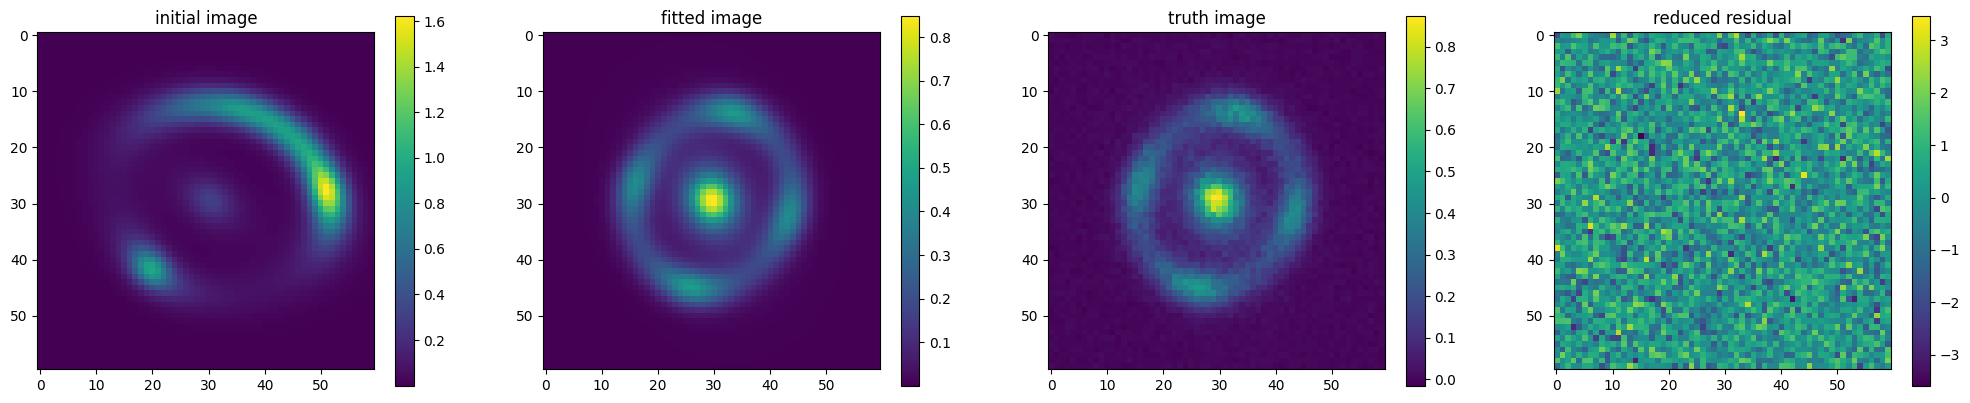

In [ ]:
kwargs_result = fitting_seq.best_fit()
kwargs_result.pop('kwargs_tracer_source', None)
fitted_image = imageModel.image(**kwargs_result)

kwargs_initial.pop('kwargs_tracer_source', None)
initial_image = imageModel.image(**kwargs_initial)

reduced_residual = (fitted_image - image_model)/np.sqrt(imageModel.Data.C_D_model(fitted_image))

images = [initial_image, fitted_image, image_model, reduced_residual]
titles = ["initial image", "fitted image", "truth image", "reduced residual"]

fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(images[i])
    plt.colorbar(im, ax=ax[i])
fig.set_figwidth(25)
plt.show()

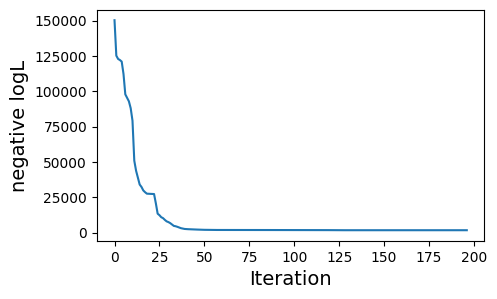

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(range(len(chain_list[-1][2])), -np.array(chain_list[-1][2]))
ax.set_ylabel("negative logL", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
plt.show()